# Bank Predictions

# Step 4: Deploy

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, './scripts')

from helpers import load_data, bank_profit, baseline_profit, perfect_profit
from Preprocessing import Preprocessing

## Automating the Pipeline

In [3]:
path = './holdout_data/'
files = ['bank_holdout.csv', 'bank_train.csv']
holdout_data = load_data(path, files[0], index=0)
train_data = load_data(path, files[1], index=0)
features_train, subscribed_train = train_data.drop(columns='y'), train_data['y']
features_holdout, subscribed_holdout = holdout_data.drop(columns='y'), holdout_data['y']
train_data.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
19687,admin.,married,university.degree,not no,yes,no,cellular,aug,thu,-1,nonexistent,1.4,93.444,-36.1,4.968,5228.1,0
3702,technician,married,university.degree,no,not yes,no,not cellular,may,fri,-1,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0
4486,technician,married,professional.course,no,not yes,no,not cellular,may,tue,-1,nonexistent,1.1,93.994,-36.4,4.856,5191.0,0
23951,technician,divorced,professional.course,not no,yes,not no,cellular,aug,fri,-1,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
7482,other,single,high.school,no,not yes,no,not cellular,may,fri,-1,nonexistent,1.1,93.994,-36.4,4.864,5191.0,0


In [4]:
p = Preprocessing(classification=True)
params = {'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1020804819179213,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 0.21603778511971944,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 985,
 'subsample': 0.7283105544694686,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
gbc = GradientBoostingClassifier().set_params(**params)
pipeline = Pipeline([('preprocessing', p), ('Gradient Boosting', gbc)])

## Deploying the Solution

In [5]:
# Fitting Pipeline
pipeline.fit(features_train, subscribed_train.values)
subscription_pred = pipeline.predict_proba(features_holdout)[:, 1]

In [6]:
%%bash
rm -r ./final_output
mkdir ./final_output

In [7]:
subscription_pred = pd.Series(subscription_pred>=.06, index=features_holdout.index)
subscription_pred.to_csv('./final_output/subscription_predictions.csv', header=True)

In [8]:
# Saving the trained model for further use if necessary for others
import joblib
joblib.dump(pipeline, './final_output/final_model.joblib')

['./final_output/final_model.joblib']

## Measuring Efficacy

In [12]:
profit_score = bank_profit(subscribed_holdout, subscription_pred)
baseline_score = baseline_profit(subscribed_holdout)
max_profit = perfect_profit(subscribed_holdout)
model_profit = profit_score*max_profit
b_profit = baseline_score*max_profit
change = (model_profit - b_profit)/b_profit * 100
print(f"Model profit score: {profit_score:.3f}")
print(f"Baseline score: {baseline_score:.3f}")
print(f"Change in score: {(profit_score - baseline_score)/baseline_score*100:.2f}%")
print(f"Baseline Profit: ${b_profit:.2f}")
print(f"Model profit: ${model_profit:.2f}")
print(f"Maximum profit: ${max_profit:.2f}")
print(f"Change in profit: {change:.2f}%")

Model profit score: 0.590
Baseline score: 0.464
Change in score: 27.20%
Baseline Profit: $7875.16
Model profit: $10017.48
Maximum profit: $16971.66
Change in profit: 27.20%


The change in profit on the holdout data when compared to the baseline strategy of calling every potential subscriber is roughly 27.20%. This can be a massive amount of capital being saved when fully utilized. The dataset comes from a singular bank when the model can be used at multiple branches. I will be describing the features which created this change in profit below, but overall, this model is a success.

## Final Summary

Text(0.5, 1.0, 'Relative Importance of Features')

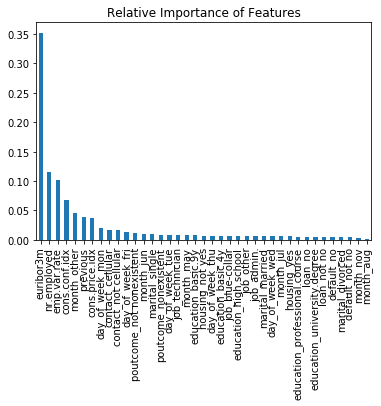

In [10]:
columns = pipeline.steps[0][1].transform(features_train.iloc[0:1,:]).columns
importances = pipeline.steps[1][1].feature_importances_

importance = pd.Series(importances, index=columns).sort_values(ascending=False)
ax = importance.plot.bar()
ax.set_title('Relative Importance of Features')

There are a few things which stand out when comparing the relative importances found by the Gradient Boosting model. The first is the massive amount of importance the *euribor3m* feature had. This makes quite a lot of sense since it is the measure of how much money a client could make on the subscription to the term deposit. If the client cannot make any money from the subscription, then they will most likely not subscribe to one. There is not much that the bank can do to control this, but they can ensure that they are capitalizing on the higher interest rates when they do come around. They could also save money by making sure campaigns are not occurring when it does not make sense for a client to subscribe. 


The first feature which is not a direct measure of the economic climate at the time is *month_other*. This was by far the feature which surprised me the most. The bank is clearly not taking advantage during months which increase subscription rates. While I was performing EDA, the month with the lowest amount of tries exhibited the highest rate of success. Maybe the lack of attempts was due to extenuating circumstances which prevented them from trying to sell more subscriptions during these months. In any case, these months should be capitalized on further.

One of the last features to do better than random noise was the *previous* feature. This is the number of calls that had occurred with this specific client during the previous campaign. It seemed to be that the more the bank tried to secure the subscription on an earlier campaign, then the more likely that client would subscribe to a term deposit on this campaign. The higher number of phone calls could also be an indication that they were interested and subscribed during the previous campaign. This could be the underlying factor causing the client subscribe again, but it is rather unclear.

Finally, the high importance of just about every economic indicator feature shows that the bank must use the features as evidence to either start or end a campaign. They must capitalize on the high interest rates and low confidence in the stock market to push their more stable term deposits. When the interest rates start to plummet, the bank needs to stop wasting resources on these endeavors unless it is absolutely necessary to the survival of the bank. This saving of revenue can be applied to any number of services to increase the banks worth and trust to clients. Most banks make money by having long term clients that trust them. Using the wasted resources to build this trust through lowering fees or bettering customer services could pay off in the long term.

## What I'll Change in Future Projects

The biggest change that I need to make is ensuring that the metric for my problem is actually the metric that I want to be optimizing on. I think that I spent the first week of working on this project bouncing from metric to metric because each one did not seem to be the one I wanted to use. At first, I was just trying to get a robust model trying to maximize the area under a precision-recall curve, but that started to make less and less sense the more I pushed on with the project. I really didn't care how my model would fair on any threshold besides the theoretical implementation threshold which I had calculated. Then, I needed to make sure that I had the right balance of precision and recall to have what I defined as the "best" model without just getting the base case of *call everyone no matter what*. I finally just decided to use my expected profit as my metric, and this made all the difference in the world when tuning and comparing models. If you want to define your own metric for Sci-kit Learn, then [here](https://scikit-learn.org/stable/modules/model_evaluation.html#defining-your-scoring-strategy-from-metric-functions) is the documentation outlining the proper way to implement it. This can be a life saver.

The next change that I want to implement is organizing and automating my EDA approach. I want to make a class for the given problem which will automatically generate all the graphs that I will be needing to inform decisions like which models should be used. This bit of software will help when I actual automate the entire pipeline. This idea stems from the problem of my helpers file becoming quite cumbersome to keep organized, especially if I kept building more functions off of it.

Speaking of automation, I want to start using more software design concepts so that in my entire process, the only thing that I will be changing is a configuration file indicating things like feature types, filenames, and models to be using. I've already been building towards this with my Preprocessing.py and ModelTuner.py files, but I want to extend this idea further to make projects more streamline and focused.

Overall, I'm quite happy with how much I struggled on my first classification project without much direction to go off. Every struggle came with a lesson that I can employ on the projects to come, and I'm looking forward to the growth I'll have in my next project. Until then, I hope you enjoyed reading my ramblings and looking at some pretty graphs.